We have two issues open
* When to stop training?
* Where to put the threshold?

We solved the first one with the BIC, but can also solve the second one using the BIC. The idea is to calculate the BIC with the threshold between every alpha and do that every iteration.

To implement that, let's get some sample data going.

In [62]:
# %% Imports
from jax import numpy as jnp, random
from modax.data.kdv import doublesoliton
from modax.models import Deepmod
from modax.training.utils import create_update
from flax import optim

from modax.training import train_max_iter
from BIC import loss_fn_SBL
from modax.training.losses.utils import precision, normal_LL
import jax
from modax.linear_model.SBL import SBL
import matplotlib.pyplot as plt

In [2]:
key = random.PRNGKey(42)

In [4]:
# Making data
x = jnp.linspace(-10, 10, 100)
t = jnp.linspace(0.1, 1.0, 10)
t_grid, x_grid = jnp.meshgrid(t, x, indexing="ij")
u = doublesoliton(x_grid, t_grid, c=[5.0, 2.0], x0=[0.0, -5.0])

X = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y = u.reshape(-1, 1)
y += 0.50 * jnp.std(y) * random.normal(key, y.shape)

In [5]:
# Training model for 2k iterations
model = Deepmod([30, 30, 30, 1])
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)

update_fn = create_update(loss_fn_SBL, (model, X, y, True))
variables = model.init(key, X)
state, params = variables.pop("params")
state = (state, {"prior_init": None})  # adding prior to state
optimizer = optimizer_def.create(params)
optimizer, state = train_max_iter(update_fn, optimizer, state, 2000,)

Loss step 0: 1465.6734619140625
Loss step 100: 623.8909301757812
Loss step 200: 156.97830200195312
Loss step 300: -396.1244812011719
Loss step 400: -629.4345092773438
Loss step 500: -811.847412109375
Loss step 600: -910.2644653320312
Loss step 700: -979.4105224609375
Loss step 800: -1039.2022705078125
Loss step 900: -1201.4581298828125
Loss step 1000: -1247.674560546875
Loss step 1100: -1258.6812744140625
Loss step 1200: -1261.8131103515625
Loss step 1300: -1263.030029296875
Loss step 1400: -1263.685302734375
Loss step 1500: -1263.6876220703125
Loss step 1600: -1264.1336669921875
Loss step 1700: -1264.3343505859375
Loss step 1800: -1264.567138671875
Loss step 1900: -1264.58642578125


Now to get the prior and stuff out.

In [8]:
model_state, loss_state = state
variables = {"params": optimizer.target, **model_state}
(prediction, dt, theta, coeffs), updated_model_state = model.apply(variables, X, mutable=list(model_state.keys()))

In [13]:
n_samples, n_features = theta.shape

# MSE stuff
tau = precision(y, prediction, 0.0, 0.0)
p_mse, MSE = normal_LL(prediction, y, tau)

# Regression stuff
# we dont want the gradient
beta_prior = (
    n_samples / 2,
    n_samples / (jax.lax.stop_gradient(tau)),
)

In [15]:
prior_init = loss_state["prior_init"]
p_reg, mn, prior, fwd_metric = SBL(
        theta,
        dt,
        prior_init=prior_init,
        hyper_prior=((1e-6, 1e-6), beta_prior),
        tol=1e-4,
        max_iter=2000,
    )

In [17]:
alpha, beta = prior[:-1], prior[-1]

In [19]:
print(alpha[:, None], alpha.shape)

[[6.7982930e+04]
 [9.5097275e+03]
 [4.0377434e+04]
 [1.1197382e+00]
 [2.7732732e+04]
 [2.7479384e-02]
 [5.1492535e+04]
 [5.7994066e+04]
 [3.4442230e+04]
 [1.1327446e+04]
 [1.0000000e+05]
 [1.0000000e+05]] (12,)


Okay let's get started

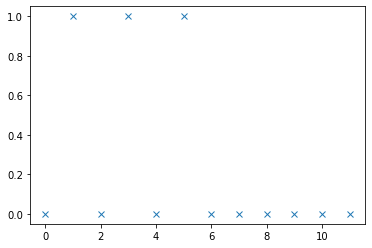

In [86]:
plt.plot(alpha < 1e4, 'x')

In [25]:
jnp.sort(alpha)

DeviceArray([2.7479384e-02, 1.1197382e+00, 9.5097275e+03, 1.1327446e+04,
             2.7732732e+04, 3.4442230e+04, 4.0377434e+04, 5.1492535e+04,
             5.7994066e+04, 6.7982930e+04, 1.0000000e+05, 1.0000000e+05],            dtype=float32)

In [28]:
thresholds = jnp.minimum(jnp.sort(alpha[:-1]) + 0.5 * jnp.diff(jnp.sort(alpha)), 1e5)

In [30]:
[alpha < threshold for threshold in thresholds]

[DeviceArray([False, False, False, False, False,  True, False, False,
              False, False, False, False], dtype=bool),
 DeviceArray([False, False, False,  True, False,  True, False, False,
              False, False, False, False], dtype=bool),
 DeviceArray([False,  True, False,  True, False,  True, False, False,
              False, False, False, False], dtype=bool),
 DeviceArray([False,  True, False,  True, False,  True, False, False,
              False,  True, False, False], dtype=bool),
 DeviceArray([False,  True, False,  True,  True,  True, False, False,
              False,  True, False, False], dtype=bool),
 DeviceArray([False,  True, False,  True,  True,  True, False, False,
               True,  True, False, False], dtype=bool),
 DeviceArray([False,  True,  True,  True,  True,  True, False, False,
               True,  True, False, False], dtype=bool),
 DeviceArray([False,  True,  True,  True,  True,  True,  True, False,
               True,  True, False, False], dtype

In [35]:
masks = jnp.stack([alpha < threshold for threshold in thresholds])

In [37]:
masks

DeviceArray([[False, False, False, False, False,  True, False, False,
              False, False, False, False],
             [False, False, False,  True, False,  True, False, False,
              False, False, False, False],
             [False,  True, False,  True, False,  True, False, False,
              False, False, False, False],
             [False,  True, False,  True, False,  True, False, False,
              False,  True, False, False],
             [False,  True, False,  True,  True,  True, False, False,
              False,  True, False, False],
             [False,  True, False,  True,  True,  True, False, False,
               True,  True, False, False],
             [False,  True,  True,  True,  True,  True, False, False,
               True,  True, False, False],
             [False,  True,  True,  True,  True,  True,  True, False,
               True,  True, False, False],
             [False,  True,  True,  True,  True,  True,  True,  True,
               True,  True

In [107]:
coeffs, regs = jax.vmap(lambda mask: jnp.linalg.lstsq(theta * jnp.where(mask == 0, 1e-7, 1.0), dt)[:2])(masks)
n_samples = theta.shape[0]
regs = regs / n_samples

In [128]:
coeffs.shape

(11, 12, 1)

In [129]:
masks.shape

(11, 12)

In [130]:
coeffs.squeeze() * masks

DeviceArray([[-0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
               0.0000000e+00, -0.0000000e+00, -3.0341907e+00,
               0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
              -0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
             [ 0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
              -9.4387782e-01, -0.0000000e+00, -6.0330334e+00,
               0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
              -0.0000000e+00,  0.0000000e+00, -0.0000000e+00],
             [-0.0000000e+00,  6.8011284e-03,  0.0000000e+00,
              -9.4518310e-01, -0.0000000e+00, -6.0414028e+00,
               0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
              -0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
             [-0.0000000e+00, -7.3647499e-04,  0.0000000e+00,
              -9.4601172e-01, -0.0000000e+00, -6.0247755e+00,
               0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
              -8.1825852e-03,  0.0000000e+00, -0.0000000e+00],
    

In [117]:
regs_self = jax.vmap(lambda w: jnp.mean(jnp.abs(dt - jnp.dot(theta, w))))(coeffs)

In [118]:
regs

DeviceArray([[1.3196992e+00],
             [4.2108790e-04],
             [4.2041834e-04],
             [4.1711077e-04],
             [1.8213567e-04],
             [8.5864747e-05],
             [6.7353802e-05],
             [6.3969041e-05],
             [6.3858213e-05],
             [6.2130501e-05],
             [6.2130501e-05]], dtype=float32)

In [119]:
regs_self

DeviceArray([0.58414257, 0.01100761, 0.01098049, 0.01095006, 0.00978881,
             0.007439  , 0.0066422 , 0.00655413, 0.0065508 , 0.00629029,
             0.00629029], dtype=float32)

In [120]:
mse = jnp.mean((prediction - y) ** 2)
L1 = n_samples * jnp.log(mse)

In [121]:
L2 = n_samples * jnp.log(regs_self.squeeze())

In [122]:
BICS = (L1 + L2) + jnp.sum(masks, axis=1) * jnp.log(n_samples)

In [123]:
jnp.sum(masks, axis=1)

DeviceArray([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 10], dtype=int32)

In [124]:
BICS

DeviceArray([-2996.6619, -6961.3125, -6956.8716, -6952.7397, -7057.936 ,
             -7325.532 , -7431.917 , -7438.358 , -7431.9575, -7465.6294,
             -7465.6294], dtype=float32)

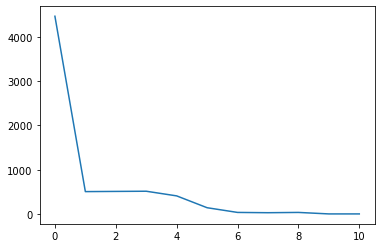

In [125]:
plt.plot(BICS - BICS.min())

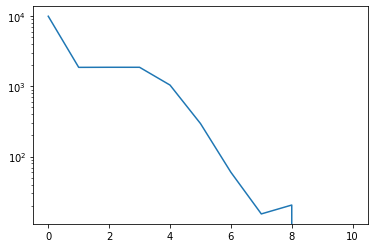

In [79]:
plt.semilogy(BICS - BICS.min())

In [81]:
jnp.log(regs)

DeviceArray([[ 0.2774038],
             [-7.772669 ],
             [-7.7742605],
             [-7.782159 ],
             [-8.610759 ],
             [-9.362738 ],
             [-9.605551 ],
             [-9.657111 ],
             [-9.658845 ],
             [-9.686274 ],
             [-9.686274 ]], dtype=float32)

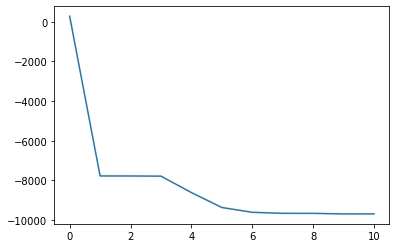

In [68]:
plt.plot(L2)

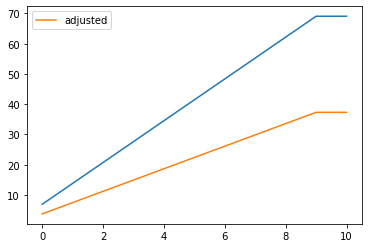

In [92]:
plt.plot(jnp.sum(masks, axis=1) * jnp.log(n_samples))
plt.plot(jnp.sum(masks, axis=1) * jnp.log((n_samples +2)/24), label='adjusted')
plt.legend()

In [ ]:
BIC = (L1 + L2) + jnp.sum(mask) * jnp.log(n_samples)

In [82]:
jnp.log(n_samples) / n_samples

DeviceArray(0.00690776, dtype=float32)